# ENSO analysis of FOCI-OpenIFS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean 
from scipy.stats import linregress

In [2]:
from dask.distributed import Client, LocalCluster, wait

In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33475 instead
  expected, actual


In [4]:
client

Client Scheduler: tcp://127.0.0.1:44931 Dashboard: http://127.0.0.1:33475/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [5]:
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
    hadisst_file = '/data/user/swahl/reanalysis_obs/HADISST/HadISST_sst.nc'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'
    hadisst_file = '/gxfs_work1/geomar/smomw352/reanalysis_obs/HadISST_sst.nc'

In [52]:
exp_list = ['FOCI_GJK001']
time_list = [slice('2350-01-01','2850-01-01')]

#exp_list = ['FOCI_GJK029']
#time_list = [slice('2200-01-01','2600-01-01')]
version = [1]

In [53]:
# OpenIFS surface
ds_sfc_all = []
for exp,time in zip(exp_list,time_list):
    sfc = '%s/%s/outdata/oifs/*1m*regular_sfc.nc' % (esmdir,exp)
    print(sfc)
    # calendar function overflows around year 2400. So we must use_cftime
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_sfc_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/*1m*regular_sfc.nc


In [54]:
# OpenIFS plev
ds_pl_all = []
for exp,time in zip(exp_list,time_list):
    pl = '%s/%s/outdata/oifs/*1m*regular_pl.nc' % (esmdir,exp)
    print(pl)
    ds_pl = xr.open_mfdataset(pl,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_pl_all.append(ds_pl)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/*1m*regular_pl.nc


In [55]:
# HadSST 
ds_hadsst = xr.open_dataset(hadisst_file).rename({'longitude':'lon','latitude':'lat'})

sst_had = ds_hadsst['sst'].where(ds_hadsst['sst'] > -50)
sst_had = sst_had.sel(time=slice('1980-01-01','2010-01-01')).reindex(lat=sst_had.lat[::-1])

# Change lon to 0,360 to match OpenIFS
lon2 = np.where(sst_had['lon'] < 0, sst_had['lon'] + 360, sst_had['lon'])
sst_had = sst_had.assign_coords({"lon": lon2}).sortby('lon')

## ENSO functions

In [56]:
def enso(sst):
    """
    """
    sst_anom = sst.groupby('time.month') - sst.groupby('time.month').mean('time')
    sst_nino = sst_anom.sel(lon=slice(210,270),lat=slice(-5,5))
    nino = sst_nino.mean(('lon','lat'))
    nino_chnk = nino.chunk({'time':100})
    nino_run = nino_chnk.rolling(time=5,center=True).mean()
    
    # Find El Nino and La Nina events
    vals = nino_run.fillna(0).values
    el_nino_cut = vals.std()
    la_nina_cut = -vals.std()
    en = np.where(vals >= el_nino_cut)
    ln = np.where(vals <= la_nina_cut)
    
    return nino_run,en,ln

<xarray.Dataset>
Dimensions:               (lat: 96, lon: 192, time: 697, axis_nbounds: 2)
Coordinates:
  * lat                   (lat) float32 -89.06 -87.19 -85.31 ... 87.19 89.06
  * lon                   (lon) float32 0.9375 2.812 4.688 ... 355.3 357.2 359.1
    time_centered         (time) object dask.array<chunksize=(11,), meta=np.ndarray>
  * time                  (time) object 2200-11-16 00:00:00 ... 2577-12-16 12...
Dimensions without coordinates: axis_nbounds
Data variables: (12/46)
    time_centered_bounds  (time, axis_nbounds) object dask.array<chunksize=(11, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) object dask.array<chunksize=(11, 2), meta=np.ndarray>
    sstk                  (time, lat, lon) float32 dask.array<chunksize=(11, 96, 192), meta=np.ndarray>
    ci                    (time, lat, lon) float32 dask.array<chunksize=(11, 96, 192), meta=np.ndarray>
    es                    (time, lat, lon) float32 dask.array<chunksize=(11, 96, 192), meta=np.ndarray>
    tclw                  (time, lat, lon) float32 dask.array<chunksize=(11, 96, 192), meta=np.ndarray>
    ...                    ...
    swvl1                 (time, lat, lon) float32 dask.array<chunksize=(11, 96, 192), meta=np.ndarray>
    swvl2                 (time, lat, lon) float32 dask.array<chunksize=(11, 96, 192), meta=np.ndarray>
    swvl3                 (time, lat, lon) float32 dask.array<chunksize=(11, 96, 192), meta=np.ndarray>
    swvl4                 (time, lat, lon) float32 dask.array<chunksize=(11, 96, 192), meta=np.ndarray>
    sro                   (time, lat, lon) float32 dask.array<chunksize=(11, 96, 192), meta=np.ndarray>
    ssro                  (time, lat, lon) float32 dask.array<chunksize=(11, 96, 192), meta=np.ndarray>
Attributes:
    name:         ECE3_1m_18500101_regular_sfc
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2023-Feb-19 13:41:02 GMT
    uuid:         3b3166db-6c1a-4d78-ba3e-27bee07b9dfe
    history:      Mon Feb 20 11:29:14 2023: ncks -7 --no-alphabetize -L 1 --c...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1

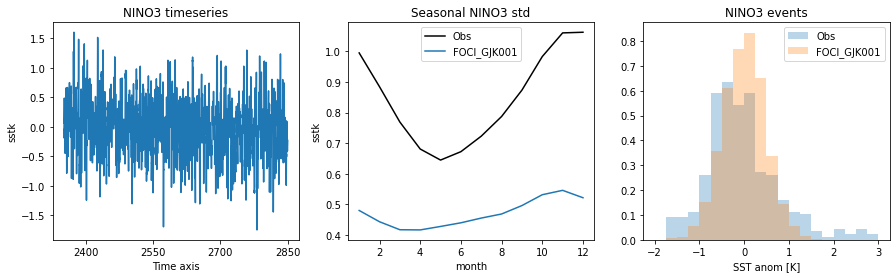

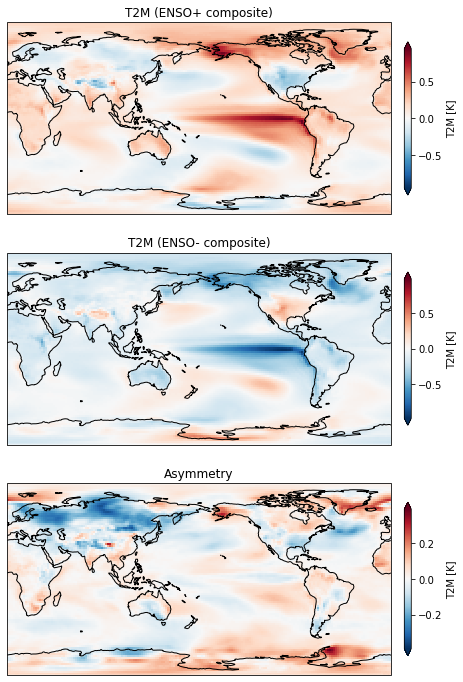

In [57]:
# Define the map projection we want for the plot
prj = ccrs.PlateCarree(central_longitude=180)
# Define the map projection for the data
prj0 = crs=ccrs.PlateCarree(central_longitude=0)

fig1, axs1 = plt.subplots(1,3,figsize=(15,4))
#fig2, axs2 = plt.subplots(len(exp_list),3,figsize=(20,5))
fig2  = plt.figure(figsize=(12,12))
axs2 = []
for i in range(0,len(exp_list)):
    for j in range(0,3):
        axs2.append( fig2.add_subplot(3,len(exp_list),j+i*3+1,projection=prj) )

# Obs ENSO
nino3_obs,elnino_obs,lanina_obs = enso(sst_had)
nino3_std = nino3_obs.groupby('time.month').std('time')
nino3_std.plot(ax=axs1[1],c='k',label='Obs')

sst_bins = np.arange(-2,3.25,0.25)
nino3_obs.plot.hist(ax=axs1[2],label='Obs',bins=sst_bins,alpha=0.3,density=True)

for i in range(0,len(exp_list)):
    exp = exp_list[i]
    ds_sfc = ds_sfc_all[i]
    sst = ds_sfc['sstk']
    t2m = ds_sfc['2t']
    
    # Compute NINO3 index and El Nino / La Nina events
    nino3,elnino,lanina = enso(sst)
    
    # Plot time series
    nino3.plot(ax=axs1[0])
    
    # Plot seasonal variance
    nino3_std = nino3.groupby('time.month').std('time')
    nino3_std.plot(ax=axs1[1],label=exp)
    
    # Histogram of events
    nino3.plot.hist(ax=axs1[2],label=exp,bins=sst_bins,alpha=0.3,density=True)
    
    # Composites of El Nino / La Nina events
    sst_anom = sst.groupby('time.month') - sst.groupby('time.month').mean('time')
    t2m_anom = t2m.groupby('time.month') - t2m.groupby('time.month').mean('time')
    
    sst_en = sst_anom[elnino].mean('time') 
    sst_ln = sst_anom[lanina].mean('time')
    t2m_en = t2m_anom[elnino].mean('time') 
    t2m_ln = t2m_anom[lanina].mean('time')
    
    ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'T2M [K]'}
    t2m_en.plot(ax=axs2[0],cbar_kwargs=ckw,transform=prj0)
    t2m_ln.plot(ax=axs2[1],cbar_kwargs=ckw,transform=prj0)
    (t2m_en + t2m_ln).plot(ax=axs2[2],cbar_kwargs=ckw,transform=prj0)
    
    for ax in axs2:
        ax.coastlines()

axs1[0].set_title('NINO3 timeseries')
axs1[1].set_title('Seasonal NINO3 std')
axs1[2].set_title('NINO3 events')
axs1[2].set_xlabel('SST anom [K]')
axs1[1].legend()
axs1[2].legend()
fig1.savefig('plots/nino3_stats.pdf',format='pdf')

axs2[0].set_title('T2M (ENSO+ composite)')
axs2[1].set_title('T2M (ENSO- composite)')
axs2[2].set_title('Asymmetry')
fig2.savefig('plots/enso_t2m_composites.pdf',format='pdf')

## Composites of fields

In [58]:
# Select variables
v = ['sstk','2t','10u','msl','tcc','tp','sshf','slhf','ttr','tsr']

ds_en_list = []
ds_ln_list = []

for i, (exp, ds) in enumerate( zip(exp_list, ds_sfc_all) ):
    
    # Compute anomalies for selected variables
    ds_anom = ds[v].groupby('time.month') - ds[v].groupby('time.month').mean('time')
    
    ## Composites of El Nino and La Nina events    
    ds_en = ds_anom.isel(time=elnino[0]).mean('time').compute()
    ds_ln = ds_anom.isel(time=lanina[0]).mean('time').compute()
    
    ds_en_list.append(ds_en)
    ds_ln_list.append(ds_ln)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1

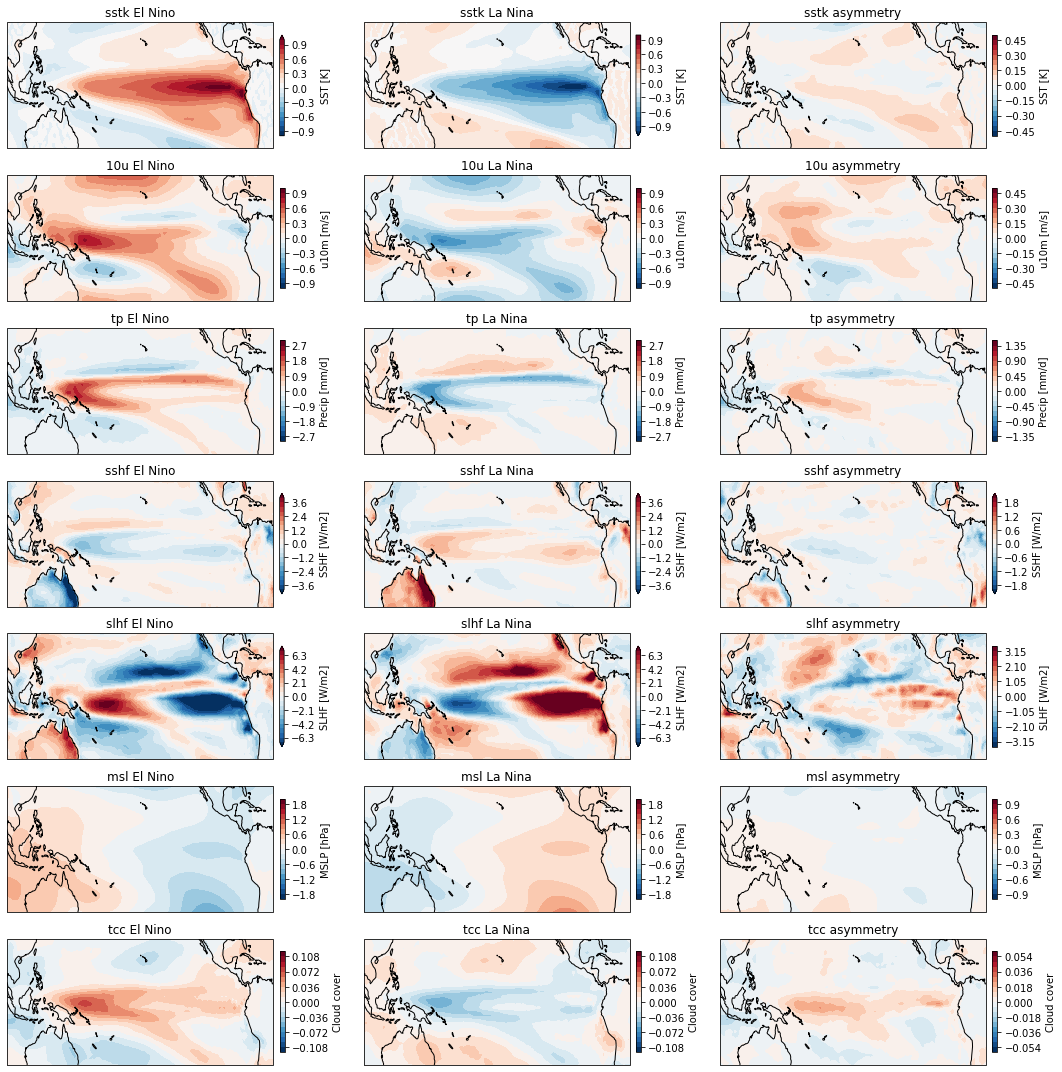

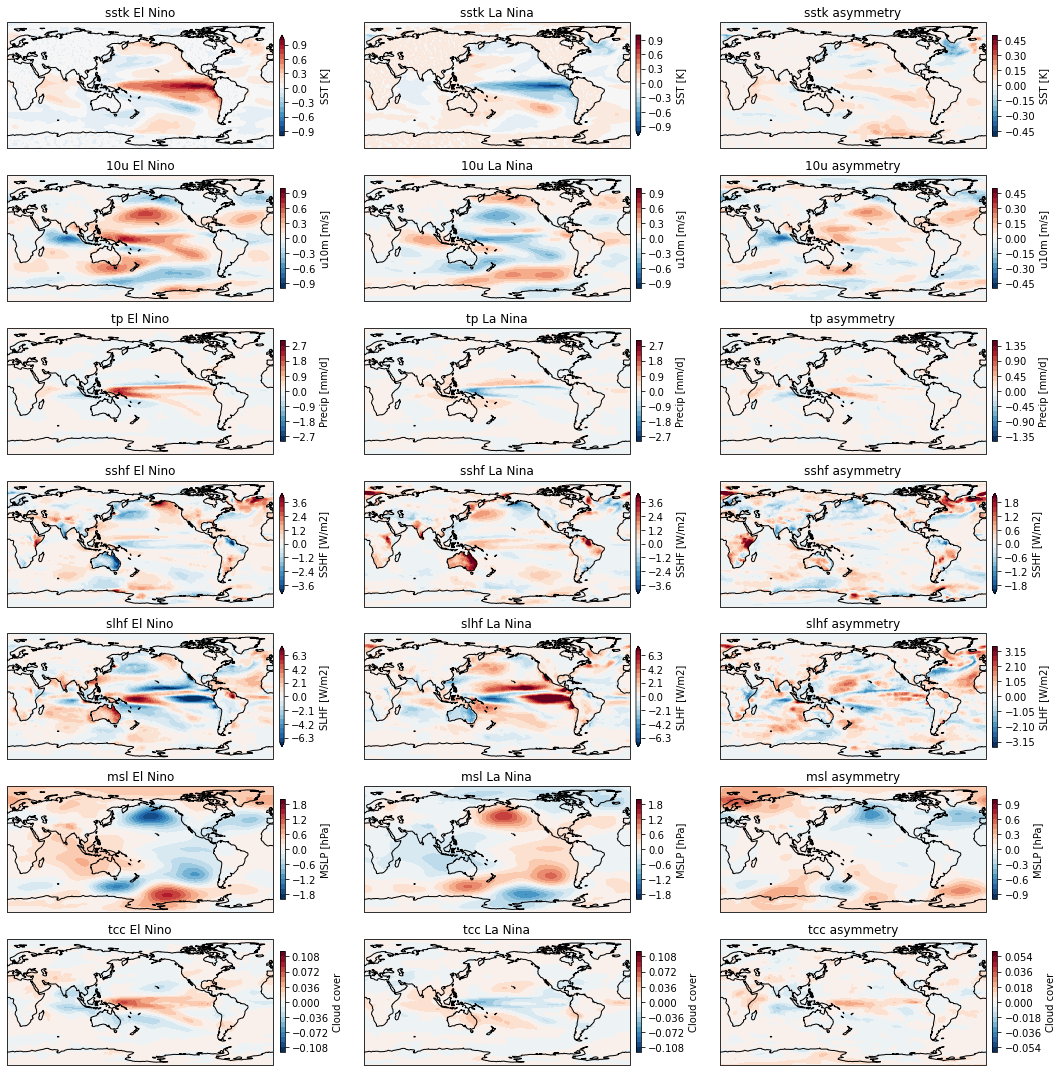

In [59]:
# Define the map projection we want for the plot
prj = ccrs.PlateCarree(central_longitude=180)
# Define the map projection for the data
prj0 = crs=ccrs.PlateCarree(central_longitude=0)

#
# Define the variables to plot
#

xios_freq = 6 #hours between XIOS calls (NFRHIS in context_ifs.xml)
flux_scale = 1.0/(xios_freq * 60 * 60)
pr_scale = 24000 / xios_freq #mm/day

sstk = {'name':'sstk', 'label': 'SST [K]', 'vmin':-1, 'vmax': 1, 'scale': 1}
sshf = {'name':'sshf', 'label': 'SSHF [W/m2]', 'vmin':-4, 'vmax': 4, 'scale': flux_scale}
slhf = {'name':'slhf', 'label': 'SLHF [W/m2]', 'vmin':-7, 'vmax': 7, 'scale': flux_scale}
u10  = {'name':'10u', 'label': 'u10m [m/s]', 'vmin':-1, 'vmax': 1, 'scale': 1}
tp   = {'name':'tp', 'label': 'Precip [mm/d]', 'vmin':-3, 'vmax': 3, 'scale': pr_scale}
msl  = {'name':'msl', 'label': 'MSLP [hPa]', 'vmin':-2, 'vmax': 2, 'scale': 1e-2}
tcc  = {'name':'tcc', 'label': 'Cloud cover', 'vmin':-0.12, 'vmax': 0.12, 'scale': 1}

variables = [sstk, u10, tp, sshf, slhf, msl, tcc]
nvars = len(variables)

for i, (ds_en, ds_ln) in enumerate( zip(ds_en_list, ds_ln_list) ):
    
    # Tropical Pacific plots
    fig1  = plt.figure(figsize=(15,15))
    axs1 = []
    for j in range(0,nvars):
        for k in range(0,3):
            # Use the projection we want to show
            axs1.append( fig1.add_subplot(nvars,3,k+j*3+1,projection=prj) )
    
    # Global plots
    fig2  = plt.figure(figsize=(15,15))
    axs2 = []
    for j in range(0,nvars):
        for k in range(0,3):
            # Use the projection we want to show
            axs2.append( fig2.add_subplot(nvars,3,k+j*3+1,projection=prj) )
    
    for j,var in enumerate(variables):
        
        name    = var['name']
        label   = var['label']
        scale   = var['scale']
        levels  = np.linspace(var['vmin'],var['vmax'],21)
        levels2 = np.linspace(var['vmin']/2,var['vmax']/2,21)
        
        # Composites of El Nino / La Nina events
        #z = ds_sfc[name] * scale
        #z_anom = z.groupby('time.month') - z.groupby('time.month').mean('time')
        
        #z_en = z_anom[elnino].mean('time') 
        #z_ln = z_anom[lanina].mean('time') 
        
        z_en = ds_en[name] * scale
        z_ln = ds_ln[name] * scale
        
        ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':label}
        
        z_en.plot.contourf(ax=axs2[0+j*3],levels=levels,cbar_kwargs=ckw,transform=prj0)
        z_ln.plot.contourf(ax=axs2[1+j*3],levels=levels,cbar_kwargs=ckw,transform=prj0)
        (z_en + z_ln).plot.contourf(ax=axs2[2+j*3],levels=levels2,cbar_kwargs=ckw,transform=prj0)
        
        # use transform so that cartopy knows the projection of the data
        z_en.plot.contourf(ax=axs1[0+j*3],levels=levels,cbar_kwargs=ckw,transform=prj0)
        z_ln.plot.contourf(ax=axs1[1+j*3],levels=levels,cbar_kwargs=ckw,transform=prj0)
        (z_en + z_ln).plot.contourf(ax=axs1[2+j*3],levels=levels2,cbar_kwargs=ckw,transform=prj0)
        
        axs1[0+j*3].set_title('%s El Nino' % (name,))
        axs1[1+j*3].set_title('%s La Nina' % (name,))
        axs1[2+j*3].set_title('%s asymmetry' % (name,))
        
        axs2[0+j*3].set_title('%s El Nino' % (name,))
        axs2[1+j*3].set_title('%s La Nina' % (name,))
        axs2[2+j*3].set_title('%s asymmetry' % (name,))
        
    for ax in axs1:
        ax.coastlines()
        ax.set_aspect('auto')
        ax.set_extent([100,300,-30,30],crs=prj0)
    
    for ax in axs2:
        ax.coastlines()
        ax.set_aspect('auto')
        
    fig1.tight_layout()
    fig2.tight_layout()
    fig1.savefig('plots/tpac_enso_composites.pdf',format='pdf')
    fig2.savefig('plots/global_enso_composites.pdf',format='pdf')